In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None

In [2]:
#Limiting data to that of the last 6 months.
from datetime import datetime
from dateutil.relativedelta import relativedelta
import calendar

now = datetime.today()
six_months = datetime.today() + relativedelta(months=-6, days = -3)
days = (now - six_months).days

utc_now = calendar.timegm(now.utctimetuple())
utc_6_months = calendar.timegm(six_months.utctimetuple())

def convert_for_price(date):
    return str(date.year) + str(date.month).zfill(2) + str(date.day).zfill(2)

def convert_date_format(date):
    return datetime.strptime(date, '%b %d, %Y').strftime('%-m/%-d/%Y')

In [3]:
#Transactions for Ethereum, Bitcoin.
import requests
import io

r_eth = requests.get('https://etherscan.io/chart/tx?output=csv')
eth_transactions = pd.read_csv(io.StringIO(r_eth.text))[-365:]
eth_transactions = eth_transactions.reset_index(drop = True)
eth_transactions.columns = ['Date', 'Unix Timestamp', 'Ethereum Transactions']

r_btc = requests.get('https://api.blockchain.info/charts/n-transactions?format=csv')
btc_transactions = pd.read_csv(io.StringIO(r_btc.text), header = None)
btc_transactions.columns = ['Date', 'Bitcoin Transactions']

transactions = eth_transactions.join(btc_transactions['Bitcoin Transactions'])[-days:]

In [4]:
#Getting price data for Ethereum, Bitcoin.
btc_price = pd.read_html('https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=' + 
                        convert_for_price(six_months) + '&end=' + convert_for_price(now))[0]
btc_price['Average'] = (btc_price['High'] + btc_price['Low'] + btc_price['Close**'])/3
btc_price = btc_price[['Date', 'Volume', 'Market Cap', 'Average']]
btc_price.columns = ['Date', 'Bitcoin Volume', 'Bitcoin Market Cap', 'Bitcoin Price']
btc_price['Bitcoin Price Change'] = btc_price['Bitcoin Price'].diff(periods=-1)*100/btc_price['Bitcoin Price']

eth_price = pd.read_html('https://coinmarketcap.com/currencies/ethereum/historical-data/?start=' + 
                        convert_for_price(six_months) + '&end=' + convert_for_price(now))[0]
eth_price['Average'] = (eth_price['High'] + eth_price['Low'] + eth_price['Close**'])/3
eth_price = eth_price[['Date', 'Volume', 'Market Cap', 'Average']]
eth_price.columns = ['Date', 'Ethereum Volume', 'Ethereum Market Cap', 'Ethereum Price']
eth_price['Ethereum Price Change'] = eth_price['Ethereum Price'].diff(periods=-1)*100/eth_price['Ethereum Price']

price = btc_price.merge(eth_price, on = 'Date')
price['Date'] = price['Date'].apply(convert_date_format)

In [5]:
#Getting subreddit data from Reddit.
import json

sub_btc = requests.get('https://api.pushshift.io/reddit/submission/search/?after=' + str(days + 1) +
                       'd&subreddit=bitcoin&aggs=created_utc&frequency=d&size=0')
sub_btc_json = sub_btc.json()
btc_subreddit = pd.DataFrame(sub_btc_json['aggs']['created_utc'])
btc_subreddit.columns = ['r/bitcoin submissions', 'UTC']
btc_subreddit = btc_subreddit[['UTC', 'r/bitcoin submissions']]

com_btc = requests.get('https://api.pushshift.io/reddit/comment/search/?after=' + str(days + 1) +
                       'd&subreddit=bitcoin&aggs=created_utc&frequency=d&size=0')
com_btc_json = com_btc.json()
btc_comments = pd.DataFrame(com_btc_json['aggs']['created_utc'])
btc_comments.columns = ['r/bitcoin comments', 'UTC']

r_bitcoin = btc_subreddit.merge(btc_comments, on = 'UTC')

sub_eth = requests.get('https://api.pushshift.io/reddit/submission/search/?after=' + str(days + 1) +
                       'd&subreddit=ethereum&aggs=created_utc&frequency=d&size=0')
sub_eth_json = sub_eth.json()
eth_subreddit = pd.DataFrame(sub_eth_json['aggs']['created_utc'])
eth_subreddit.columns = ['r/ethereum submissions', 'UTC']

com_eth = requests.get('https://api.pushshift.io/reddit/comment/search/?after=' + str(days + 1) +
                       'd&subreddit=ethereum&aggs=created_utc&frequency=d&size=0')
com_eth_json = com_eth.json()
eth_comments = pd.DataFrame(com_eth_json['aggs']['created_utc'])
eth_comments.columns = ['r/ethereum comments', 'UTC']

r_ethereum = eth_subreddit.merge(eth_comments, on = 'UTC')

reddit = r_bitcoin.merge(r_ethereum, on = 'UTC')

In [6]:
#Merging the data together.
data = reddit.merge(transactions, left_on = 'UTC', right_on = 'Unix Timestamp')
data = data.drop('Unix Timestamp', axis = 1)
data = data.merge(price, on = 'Date')

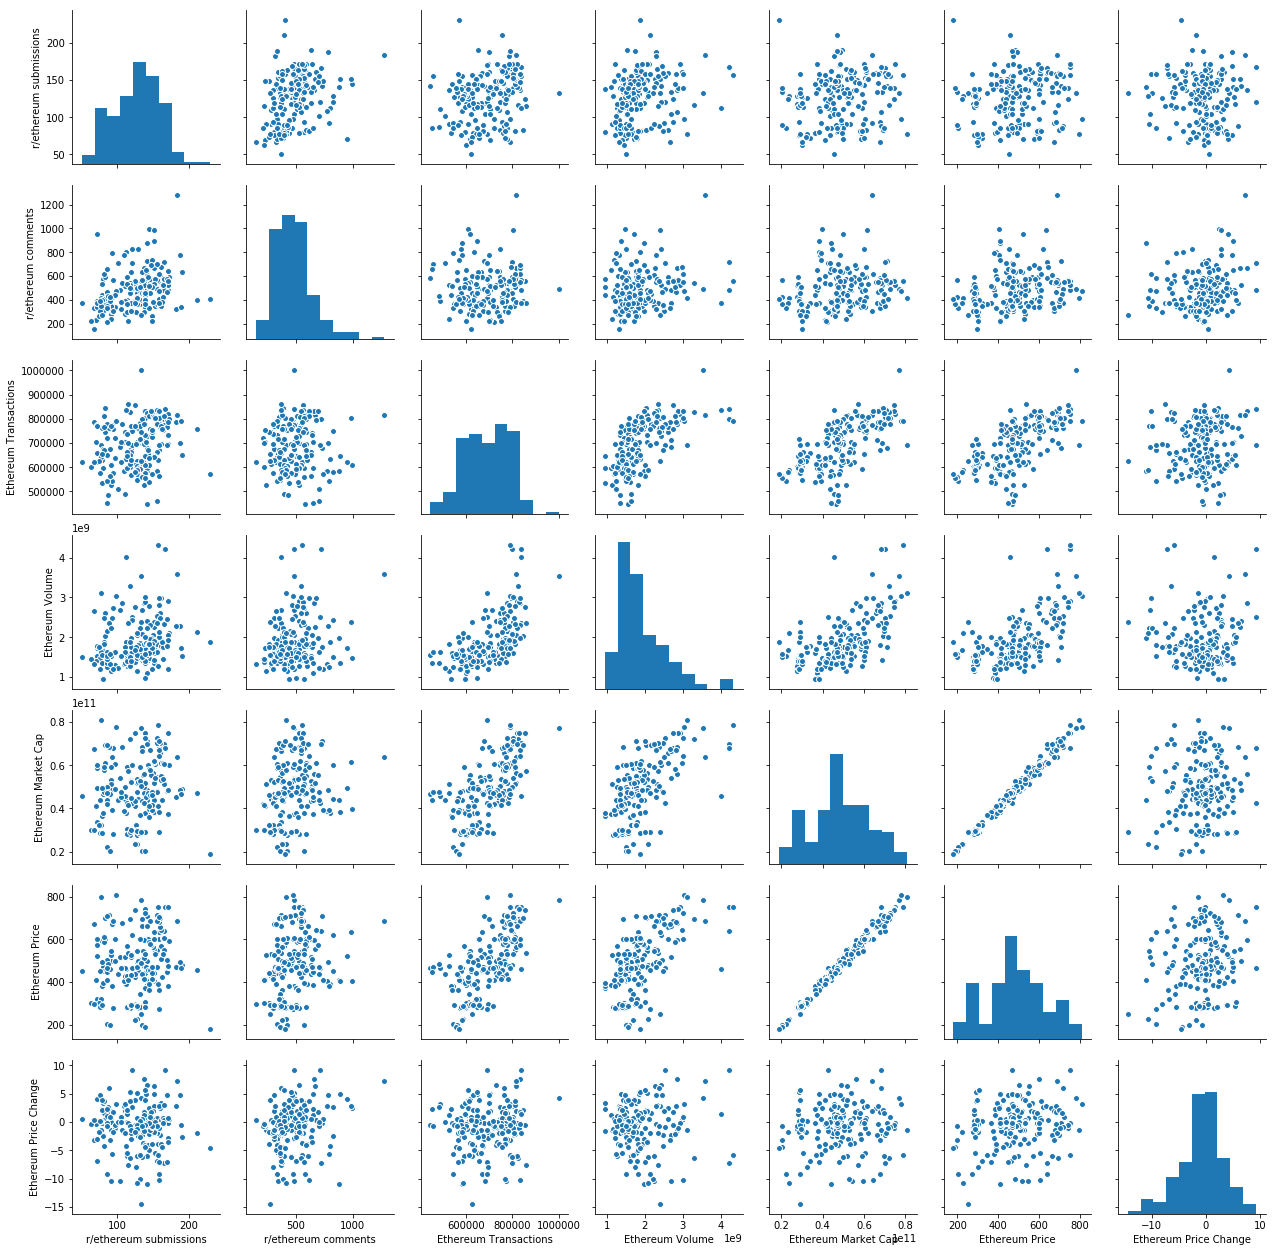

,r/ethereum submissions,r/ethereum comments,Ethereum Transactions,Ethereum Volume,Ethereum Market Cap,Ethereum Price,Ethereum Price Change
r/ethereum submissions,1.000000,0.316403,0.242423,0.253939,0.121187,0.112791,-0.068134
r/ethereum comments,0.316403,1.000000,0.020250,0.195697,0.200441,0.233046,0.220095
Ethereum Transactions,0.242423,0.020250,1.000000,0.636104,0.665363,0.662142,0.104455
Ethereum Volume,0.253939,0.195697,0.636104,1.000000,0.610658,0.605245,0.022288
Ethereum Market Cap,0.121187,0.200441,0.665363,0.610658,1.000000,0.992074,0.098050
Ethereum Price,0.112791,0.233046,0.662142,0.605245,0.992074,1.000000,0.201397
Ethereum Price Change,-0.068134,0.220095,0.104455,0.022288,0.098050,0.201397,1.000000


In [7]:
#Extracting the ethereum data to a dataframe.
ethereum = data[['Date', 'r/ethereum submissions', 'r/ethereum comments', 'Ethereum Transactions', 
                 'Ethereum Volume', 'Ethereum Market Cap', 'Ethereum Price', 'Ethereum Price Change']]
ethereum = ethereum.dropna()

sns.pairplot(ethereum)
plt.show()

ethereum.corr(method='pearson', min_periods=1)

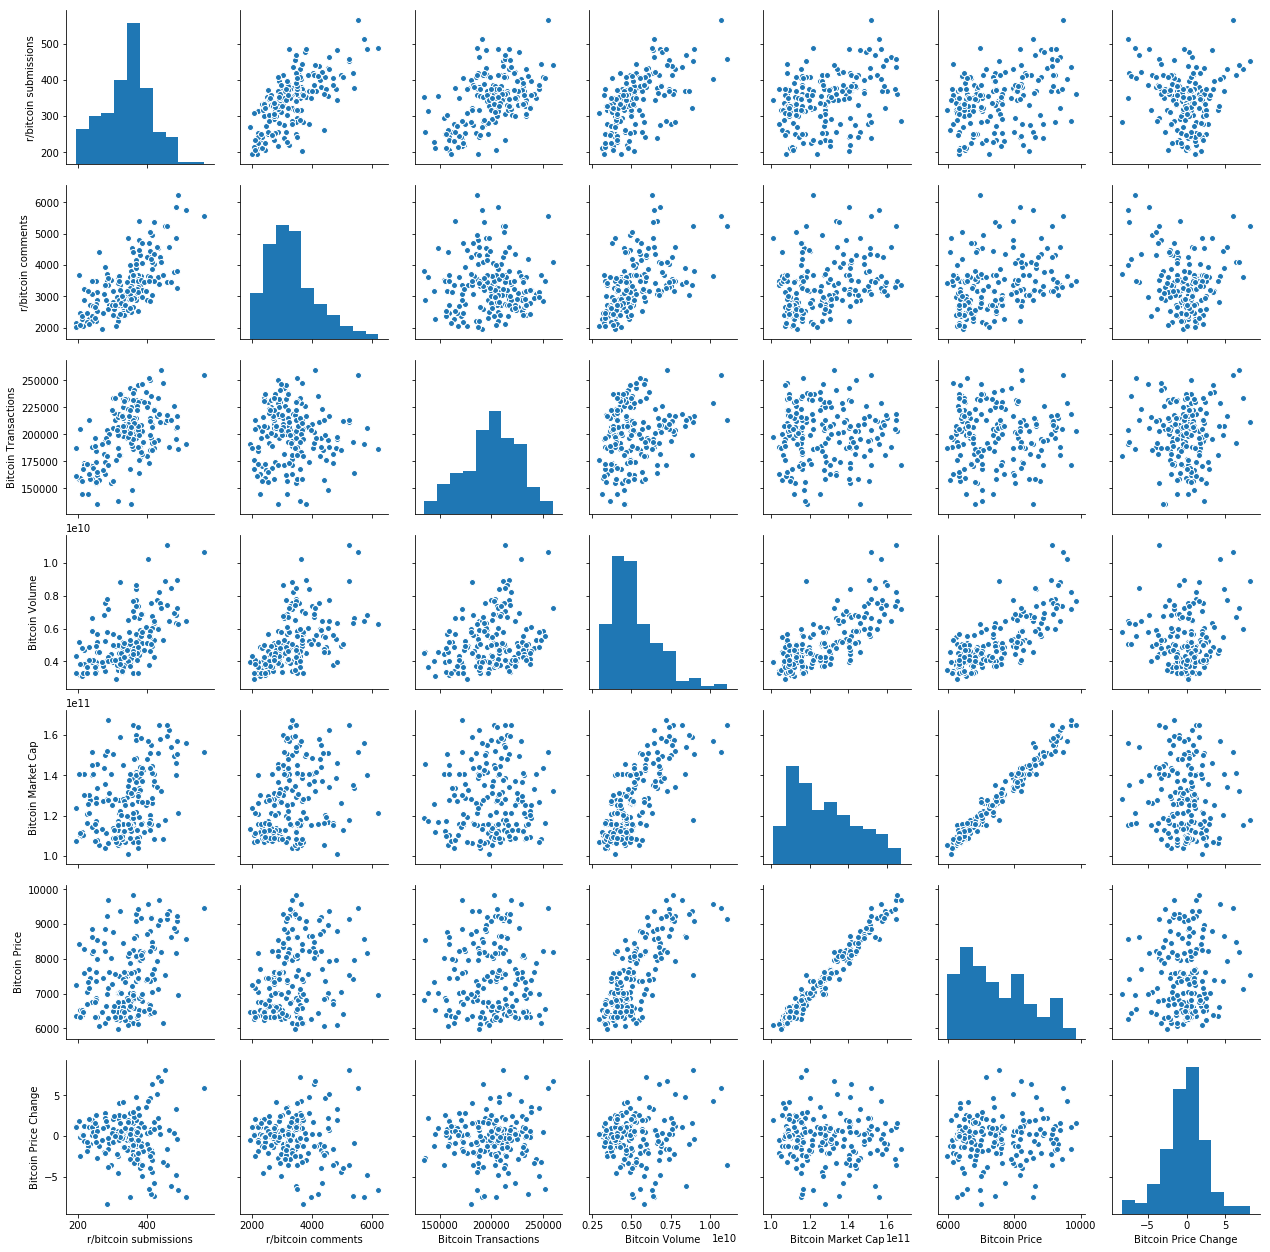

,r/bitcoin submissions,r/bitcoin comments,Bitcoin Transactions,Bitcoin Volume,Bitcoin Market Cap,Bitcoin Price,Bitcoin Price Change
r/bitcoin submissions,1.000000,0.672162,0.509956,0.573403,0.345268,0.338787,-0.090609
r/bitcoin comments,0.672162,1.000000,-0.016810,0.520957,0.301316,0.304554,-0.141490
Bitcoin Transactions,0.509956,-0.016810,1.000000,0.237707,0.013573,0.001687,0.042420
Bitcoin Volume,0.573403,0.520957,0.237707,1.000000,0.754426,0.776378,0.079058
Bitcoin Market Cap,0.345268,0.301316,0.013573,0.754426,1.000000,0.982469,-0.075812
Bitcoin Price,0.338787,0.304554,0.001687,0.776378,0.982469,1.000000,0.083906
Bitcoin Price Change,-0.090609,-0.141490,0.042420,0.079058,-0.075812,0.083906,1.000000


In [8]:
#Extracting the bitcoin data to a dataframe.
bitcoin = data[['Date', 'r/bitcoin submissions', 'r/bitcoin comments', 'Bitcoin Transactions', 
                 'Bitcoin Volume', 'Bitcoin Market Cap', 'Bitcoin Price', 'Bitcoin Price Change']]
bitcoin = bitcoin.dropna()

sns.pairplot(bitcoin)
plt.show()

bitcoin.corr(method='pearson', min_periods=1)

# Attribution

etherscan.io

blockchain.com

coinmarketcap.com